In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

As in previous exercises, we will train a regression model to predict a person's weight from their height. The model is linear regression with one explanatory variable (weight) and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
b.shape, A.shape

((10000,), (10000, 2))

# Least Squares Estimation
Least squares estimation is one of the fundamental machine learning algorithms. Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function $$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

In this exercise, we will try to fit $x$ using Least Squares Estimation. 

One can see the function is $\mu$ strongly convex with $\mu = \lambda_{max}(\nabla^2 f(x))$ and $L$ smooth with $L = \lambda_{min}(\nabla^2 f(x)$ everywhere, since here the Hessian matrix is constant, independent of $x$.



# Stochastic Gradient Descent

Please fill in the function `minibatch_gradient` below:

In [4]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    batch_size = len(targets_b)
    err = targets_b - data_A.dot(params_x)
    grad = -data_A.T.dot(err) / batch_size
    return grad

Verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

In [5]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    # Compute the mean of all stochastic gradient for mini-batch size 1
    stochastic_gradients = []
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(b[i:i+1], A[i:i+1, :], x))

    # Compute the full gradient
    full_gradient = minibatch_gradient(b, A, x)

    # Those should be the same on average
    assert np.allclose(np.mean(stochastic_gradients, axis=0), full_gradient)
    
print('Tests passed')


Tests passed


Now, implement stochastic gradient descent for Linear Least Squares, below.


In [6]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def full_objective(targets_b, data_A, params_x):
    """Compute the least squares objective over the whole dataset"""
    return 0.5 * np.mean(((data_A @ params_x) - targets_b)**2)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay linearly to 0 at max_iters
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate

        # update x through the stochastic gradient update
        x = x - lr * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        
        print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
              bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Now it is time to test your optimizer with a naive step size with the example code below.

In [7]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.2
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    1757.10
SGD(0001/0199): objective =    1181.91
SGD(0002/0199): objective =     680.63
SGD(0003/0199): objective =     534.84
SGD(0004/0199): objective =     504.87
SGD(0005/0199): objective =     127.37
SGD(0006/0199): objective =      81.73
SGD(0007/0199): objective =      78.50
SGD(0008/0199): objective =      77.12
SGD(0009/0199): objective =      76.37
SGD(0010/0199): objective =      48.43
SGD(0011/0199): objective =      40.19
SGD(0012/0199): objective =      19.20
SGD(0013/0199): objective =      21.77
SGD(0014/0199): objective =      16.97
SGD(0015/0199): objective =      16.92
SGD(0016/0199): objective =      17.31
SGD(0017/0199): objective =      15.97
SGD(0018/0199): objective =      17.60
SGD(0019/0199): objective =      16.10
SGD(0020/0199): objective =      16.27
SGD(0021/0199): objective =      16.52
SGD(0022/0199): objective =      16.20
SGD(0023/0199): objective =      15.65
SGD(0024/0199): objective =      15.56
SGD(0025/0199): objective

Time Visualization

In [8]:
from plots import gradient_descent_visualization
from ipywidgets import IntSlider, interact
from grid_search import *

# Generate grid data for visualization (parameters to be swept and best combination)
grid_x0, grid_x1 = generate_w(num_intervals=10)
grid_objectives = grid_search(b, A, grid_x0, grid_x1)
loss_star, x0_star, x1_star = get_best_parameters(grid_x0, grid_x1, grid_objectives)

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_objectives, sgd_xs, grid_objectives, grid_x0, grid_x1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Better Learning Rate

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq 25$ containing all iterates (and we assume $\|x-x^\star\| \leq 25$ as well, for simplicity). By $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, one can see that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top Ab\|)$. We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [9]:
grad_norm_bound = (25*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))/A.shape[0]

# Define the parameters of the algorithm.
max_iters = 200

gamma = 25 / (grad_norm_bound * np.sqrt(max_iters)) # Fill in a better learning rate  

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    2721.70
SGD(0001/0199): objective =    2619.10
SGD(0002/0199): objective =    2577.56
SGD(0003/0199): objective =    2487.11
SGD(0004/0199): objective =    2429.39
SGD(0005/0199): objective =    2327.49
SGD(0006/0199): objective =    2279.61
SGD(0007/0199): objective =    2241.48
SGD(0008/0199): objective =    2124.88
SGD(0009/0199): objective =    2085.29
SGD(0010/0199): objective =    2049.43
SGD(0011/0199): objective =    2006.20
SGD(0012/0199): objective =    1980.17
SGD(0013/0199): objective =    1945.40
SGD(0014/0199): objective =    1922.54
SGD(0015/0199): objective =    1864.00
SGD(0016/0199): objective =    1814.67
SGD(0017/0199): objective =    1685.10
SGD(0018/0199): objective =    1607.27
SGD(0019/0199): objective =    1539.55
SGD(0020/0199): objective =    1464.37
SGD(0021/0199): objective =    1433.74
SGD(0022/0199): objective =    1411.36
SGD(0023/0199): objective =    1399.82
SGD(0024/0199): objective =    1308.19
SGD(0025/0199): objective

Time visualization with a better learning rate

In [10]:
interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs_dec_gamma)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

## SGD using strong convexity
Try doing SGD with a better learning rate using the fact that the objective function is strongly convex.<br>
(Hint: you can use a decreasing stepsize parameter gamma in stochastic_gradient_descent.)

In [11]:
# Define the parameters of the algorithm.
max_iters = 200

# You may use these results from last week
mu = np.linalg.norm(A, -2)**2 / len(A)
L = np.linalg.norm(A, 2)**2 / len(A)

gamma0 = 2 / mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    3588.39
SGD(0001/0199): objective =     502.18
SGD(0002/0199): objective =     438.23
SGD(0003/0199): objective =     197.84
SGD(0004/0199): objective =      34.59
SGD(0005/0199): objective =      30.54
SGD(0006/0199): objective =      18.60
SGD(0007/0199): objective =      18.50
SGD(0008/0199): objective =      25.61
SGD(0009/0199): objective =      15.50
SGD(0010/0199): objective =      15.82
SGD(0011/0199): objective =      15.58
SGD(0012/0199): objective =      15.59
SGD(0013/0199): objective =      15.61
SGD(0014/0199): objective =      15.64
SGD(0015/0199): objective =      17.15
SGD(0016/0199): objective =      17.17
SGD(0017/0199): objective =      15.51
SGD(0018/0199): objective =      15.95
SGD(0019/0199): objective =      15.68
SGD(0020/0199): objective =      15.95
SGD(0021/0199): objective =      16.34
SGD(0022/0199): objective =      16.30
SGD(0023/0199): objective =      16.80
SGD(0024/0199): objective =      16.49
SGD(0025/0199): objective

## Evolution of the objective function

Make sure to copy your code for the gradient descent implementation from lab03 into the file gradient_descent.py

Run the following code to compare SGD (with diffent stepsizes) and gradient descent with respect to the number of gradient computations needed per iteration (remember that gradient descent computes n gradients per iterations)

In [12]:
from gradient_descent import gradient_descent
x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, 3, 1/L)

sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 0.2)
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, #fill in the learning rate used above#,
    decreasing_gamma = True)

Gradient Descent(0/2): objective=2792.2367127591674
Gradient Descent(1/2): objective=15.3858878688294
Gradient Descent(2/2): objective=15.3858878688294
SGD(0000/19999): objective =    1509.43
SGD(0001/19999): objective =     880.87
SGD(0002/19999): objective =     515.34
SGD(0003/19999): objective =     342.80
SGD(0004/19999): objective =     230.14
SGD(0005/19999): objective =     191.72
SGD(0006/19999): objective =     102.59
SGD(0007/19999): objective =      56.29
SGD(0008/19999): objective =      39.92
SGD(0009/19999): objective =      34.39
SGD(0010/19999): objective =      26.31
SGD(0011/19999): objective =      24.13
SGD(0012/19999): objective =      16.26
SGD(0013/19999): objective =      15.61
SGD(0014/19999): objective =      15.58
SGD(0015/19999): objective =      15.59
SGD(0016/19999): objective =      16.08
SGD(0017/19999): objective =      22.83
SGD(0018/19999): objective =      22.79
SGD(0019/19999): objective =      22.69
SGD(0020/19999): objective =      25.14
SGD(0021

SGD(0332/19999): objective =      15.70
SGD(0333/19999): objective =      16.28
SGD(0334/19999): objective =      16.50
SGD(0335/19999): objective =      15.72
SGD(0336/19999): objective =      17.02
SGD(0337/19999): objective =      25.18
SGD(0338/19999): objective =      17.76
SGD(0339/19999): objective =      17.76
SGD(0340/19999): objective =      36.46
SGD(0341/19999): objective =      16.10
SGD(0342/19999): objective =      17.25
SGD(0343/19999): objective =      18.76
SGD(0344/19999): objective =      21.24
SGD(0345/19999): objective =      25.15
SGD(0346/19999): objective =      25.98
SGD(0347/19999): objective =      22.91
SGD(0348/19999): objective =      22.82
SGD(0349/19999): objective =      22.92
SGD(0350/19999): objective =      28.02
SGD(0351/19999): objective =      34.90
SGD(0352/19999): objective =      33.13
SGD(0353/19999): objective =      29.89
SGD(0354/19999): objective =      31.44
SGD(0355/19999): objective =      25.59
SGD(0356/19999): objective =      22.12


SGD(0681/19999): objective =      17.44
SGD(0682/19999): objective =      19.96
SGD(0683/19999): objective =      18.78
SGD(0684/19999): objective =      21.34
SGD(0685/19999): objective =      17.16
SGD(0686/19999): objective =      16.01
SGD(0687/19999): objective =      16.97
SGD(0688/19999): objective =      20.97
SGD(0689/19999): objective =      16.89
SGD(0690/19999): objective =      15.53
SGD(0691/19999): objective =      18.61
SGD(0692/19999): objective =      18.98
SGD(0693/19999): objective =      19.59
SGD(0694/19999): objective =      22.88
SGD(0695/19999): objective =      16.80
SGD(0696/19999): objective =      16.57
SGD(0697/19999): objective =      16.15
SGD(0698/19999): objective =      16.17
SGD(0699/19999): objective =      17.59
SGD(0700/19999): objective =      17.32
SGD(0701/19999): objective =      16.74
SGD(0702/19999): objective =      17.10
SGD(0703/19999): objective =      16.48
SGD(0704/19999): objective =      17.48
SGD(0705/19999): objective =      18.02


SGD(1170/19999): objective =      27.68
SGD(1171/19999): objective =      25.01
SGD(1172/19999): objective =      30.08
SGD(1173/19999): objective =      28.99
SGD(1174/19999): objective =      24.08
SGD(1175/19999): objective =      28.66
SGD(1176/19999): objective =      21.75
SGD(1177/19999): objective =      21.05
SGD(1178/19999): objective =      17.76
SGD(1179/19999): objective =      20.04
SGD(1180/19999): objective =      25.91
SGD(1181/19999): objective =      23.01
SGD(1182/19999): objective =      28.78
SGD(1183/19999): objective =      23.37
SGD(1184/19999): objective =      17.09
SGD(1185/19999): objective =      17.85
SGD(1186/19999): objective =      19.82
SGD(1187/19999): objective =      25.01
SGD(1188/19999): objective =      26.22
SGD(1189/19999): objective =      20.86
SGD(1190/19999): objective =      22.53
SGD(1191/19999): objective =      20.31
SGD(1192/19999): objective =      18.28
SGD(1193/19999): objective =      19.40
SGD(1194/19999): objective =      18.55


SGD(1519/19999): objective =      17.07
SGD(1520/19999): objective =      15.43
SGD(1521/19999): objective =      15.87
SGD(1522/19999): objective =      16.57
SGD(1523/19999): objective =      16.45
SGD(1524/19999): objective =      18.18
SGD(1525/19999): objective =      25.99
SGD(1526/19999): objective =      21.84
SGD(1527/19999): objective =      25.40
SGD(1528/19999): objective =      27.86
SGD(1529/19999): objective =      16.52
SGD(1530/19999): objective =      15.87
SGD(1531/19999): objective =      15.64
SGD(1532/19999): objective =      20.84
SGD(1533/19999): objective =      23.49
SGD(1534/19999): objective =      19.97
SGD(1535/19999): objective =      17.32
SGD(1536/19999): objective =      17.70
SGD(1537/19999): objective =      17.59
SGD(1538/19999): objective =      18.17
SGD(1539/19999): objective =      16.94
SGD(1540/19999): objective =      15.66
SGD(1541/19999): objective =      15.87
SGD(1542/19999): objective =      15.75
SGD(1543/19999): objective =      15.45


SGD(1921/19999): objective =      21.06
SGD(1922/19999): objective =      23.78
SGD(1923/19999): objective =      24.15
SGD(1924/19999): objective =      21.90
SGD(1925/19999): objective =      21.70
SGD(1926/19999): objective =      21.95
SGD(1927/19999): objective =      18.26
SGD(1928/19999): objective =      17.82
SGD(1929/19999): objective =      18.56
SGD(1930/19999): objective =      20.64
SGD(1931/19999): objective =      18.77
SGD(1932/19999): objective =      21.27
SGD(1933/19999): objective =      20.74
SGD(1934/19999): objective =      21.07
SGD(1935/19999): objective =      24.04
SGD(1936/19999): objective =      26.75
SGD(1937/19999): objective =      25.74
SGD(1938/19999): objective =      25.70
SGD(1939/19999): objective =      27.51
SGD(1940/19999): objective =      25.26
SGD(1941/19999): objective =      23.28
SGD(1942/19999): objective =      27.08
SGD(1943/19999): objective =      16.13
SGD(1944/19999): objective =      19.60
SGD(1945/19999): objective =      26.53


SGD(2310/19999): objective =      15.46
SGD(2311/19999): objective =      16.44
SGD(2312/19999): objective =      17.12
SGD(2313/19999): objective =      15.63
SGD(2314/19999): objective =      16.33
SGD(2315/19999): objective =      17.69
SGD(2316/19999): objective =      18.93
SGD(2317/19999): objective =      16.54
SGD(2318/19999): objective =      16.28
SGD(2319/19999): objective =      15.99
SGD(2320/19999): objective =      17.09
SGD(2321/19999): objective =      16.53
SGD(2322/19999): objective =      15.71
SGD(2323/19999): objective =      15.76
SGD(2324/19999): objective =      15.66
SGD(2325/19999): objective =      16.21
SGD(2326/19999): objective =      16.19
SGD(2327/19999): objective =      15.97
SGD(2328/19999): objective =      22.03
SGD(2329/19999): objective =      21.88
SGD(2330/19999): objective =      22.05
SGD(2331/19999): objective =      22.13
SGD(2332/19999): objective =      23.44
SGD(2333/19999): objective =      25.55
SGD(2334/19999): objective =      20.14


SGD(2705/19999): objective =      16.78
SGD(2706/19999): objective =      18.65
SGD(2707/19999): objective =      19.40
SGD(2708/19999): objective =      40.67
SGD(2709/19999): objective =      36.72
SGD(2710/19999): objective =      45.08
SGD(2711/19999): objective =      44.66
SGD(2712/19999): objective =      27.62
SGD(2713/19999): objective =      30.66
SGD(2714/19999): objective =      26.52
SGD(2715/19999): objective =      29.61
SGD(2716/19999): objective =      30.96
SGD(2717/19999): objective =      28.01
SGD(2718/19999): objective =      27.87
SGD(2719/19999): objective =      20.50
SGD(2720/19999): objective =      34.93
SGD(2721/19999): objective =      29.51
SGD(2722/19999): objective =      30.32
SGD(2723/19999): objective =      24.87
SGD(2724/19999): objective =      21.72
SGD(2725/19999): objective =      21.43
SGD(2726/19999): objective =      20.56
SGD(2727/19999): objective =      19.45
SGD(2728/19999): objective =      23.31
SGD(2729/19999): objective =      19.07


SGD(3093/19999): objective =      20.85
SGD(3094/19999): objective =      19.65
SGD(3095/19999): objective =      23.67
SGD(3096/19999): objective =      19.08
SGD(3097/19999): objective =      15.57
SGD(3098/19999): objective =      15.71
SGD(3099/19999): objective =      15.39
SGD(3100/19999): objective =      15.44
SGD(3101/19999): objective =      15.45
SGD(3102/19999): objective =      16.12
SGD(3103/19999): objective =      16.03
SGD(3104/19999): objective =      15.70
SGD(3105/19999): objective =      15.71
SGD(3106/19999): objective =      16.18
SGD(3107/19999): objective =      16.00
SGD(3108/19999): objective =      17.06
SGD(3109/19999): objective =      17.35
SGD(3110/19999): objective =      19.40
SGD(3111/19999): objective =      20.44
SGD(3112/19999): objective =      19.40
SGD(3113/19999): objective =      17.61
SGD(3114/19999): objective =      19.09
SGD(3115/19999): objective =      18.86
SGD(3116/19999): objective =      15.49
SGD(3117/19999): objective =      22.89


SGD(3619/19999): objective =      16.56
SGD(3620/19999): objective =      18.16
SGD(3621/19999): objective =      20.57
SGD(3622/19999): objective =      20.98
SGD(3623/19999): objective =      20.68
SGD(3624/19999): objective =      18.43
SGD(3625/19999): objective =      18.41
SGD(3626/19999): objective =      19.56
SGD(3627/19999): objective =      16.70
SGD(3628/19999): objective =      16.73
SGD(3629/19999): objective =      16.79
SGD(3630/19999): objective =      17.28
SGD(3631/19999): objective =      16.46
SGD(3632/19999): objective =      16.74
SGD(3633/19999): objective =      16.15
SGD(3634/19999): objective =      15.47
SGD(3635/19999): objective =      15.80
SGD(3636/19999): objective =      16.00
SGD(3637/19999): objective =      15.48
SGD(3638/19999): objective =      15.98
SGD(3639/19999): objective =      16.47
SGD(3640/19999): objective =      17.59
SGD(3641/19999): objective =      18.82
SGD(3642/19999): objective =      19.54
SGD(3643/19999): objective =      23.66


SGD(4190/19999): objective =      21.15
SGD(4191/19999): objective =      20.84
SGD(4192/19999): objective =      20.92
SGD(4193/19999): objective =      18.47
SGD(4194/19999): objective =      15.77
SGD(4195/19999): objective =      16.00
SGD(4196/19999): objective =      19.46
SGD(4197/19999): objective =      19.27
SGD(4198/19999): objective =      17.02
SGD(4199/19999): objective =      15.69
SGD(4200/19999): objective =      15.87
SGD(4201/19999): objective =      16.20
SGD(4202/19999): objective =      15.94
SGD(4203/19999): objective =      15.69
SGD(4204/19999): objective =      17.55
SGD(4205/19999): objective =      16.70
SGD(4206/19999): objective =      17.05
SGD(4207/19999): objective =      17.02
SGD(4208/19999): objective =      17.36
SGD(4209/19999): objective =      16.60
SGD(4210/19999): objective =      17.00
SGD(4211/19999): objective =      19.67
SGD(4212/19999): objective =      20.91
SGD(4213/19999): objective =      18.40
SGD(4214/19999): objective =      18.39


SGD(4647/19999): objective =      15.81
SGD(4648/19999): objective =      18.41
SGD(4649/19999): objective =      18.09
SGD(4650/19999): objective =      18.23
SGD(4651/19999): objective =      17.95
SGD(4652/19999): objective =      17.29
SGD(4653/19999): objective =      16.40
SGD(4654/19999): objective =      18.63
SGD(4655/19999): objective =      18.74
SGD(4656/19999): objective =      16.95
SGD(4657/19999): objective =      15.63
SGD(4658/19999): objective =      15.70
SGD(4659/19999): objective =      16.44
SGD(4660/19999): objective =      15.50
SGD(4661/19999): objective =      15.93
SGD(4662/19999): objective =      15.60
SGD(4663/19999): objective =      20.44
SGD(4664/19999): objective =      16.51
SGD(4665/19999): objective =      16.69
SGD(4666/19999): objective =      18.70
SGD(4667/19999): objective =      18.15
SGD(4668/19999): objective =      18.03
SGD(4669/19999): objective =      17.80
SGD(4670/19999): objective =      17.71
SGD(4671/19999): objective =      24.54


SGD(5074/19999): objective =      15.84
SGD(5075/19999): objective =      19.03
SGD(5076/19999): objective =      19.87
SGD(5077/19999): objective =      16.81
SGD(5078/19999): objective =      17.50
SGD(5079/19999): objective =      17.66
SGD(5080/19999): objective =      17.38
SGD(5081/19999): objective =      18.78
SGD(5082/19999): objective =      20.12
SGD(5083/19999): objective =      22.62
SGD(5084/19999): objective =      19.04
SGD(5085/19999): objective =      26.53
SGD(5086/19999): objective =      26.75
SGD(5087/19999): objective =      28.57
SGD(5088/19999): objective =      19.25
SGD(5089/19999): objective =      20.53
SGD(5090/19999): objective =      20.22
SGD(5091/19999): objective =      19.01
SGD(5092/19999): objective =      15.58
SGD(5093/19999): objective =      15.47
SGD(5094/19999): objective =      17.11
SGD(5095/19999): objective =      18.66
SGD(5096/19999): objective =      18.61
SGD(5097/19999): objective =      16.68
SGD(5098/19999): objective =      16.95


SGD(5479/19999): objective =      17.25
SGD(5480/19999): objective =      16.94
SGD(5481/19999): objective =      16.72
SGD(5482/19999): objective =      19.42
SGD(5483/19999): objective =      17.58
SGD(5484/19999): objective =      20.00
SGD(5485/19999): objective =      23.45
SGD(5486/19999): objective =      19.02
SGD(5487/19999): objective =      21.97
SGD(5488/19999): objective =      20.27
SGD(5489/19999): objective =      16.49
SGD(5490/19999): objective =      21.88
SGD(5491/19999): objective =      28.10
SGD(5492/19999): objective =      27.59
SGD(5493/19999): objective =      29.20
SGD(5494/19999): objective =      19.35
SGD(5495/19999): objective =      15.81
SGD(5496/19999): objective =      17.08
SGD(5497/19999): objective =      15.65
SGD(5498/19999): objective =      15.43
SGD(5499/19999): objective =      16.82
SGD(5500/19999): objective =      16.97
SGD(5501/19999): objective =      16.30
SGD(5502/19999): objective =      21.01
SGD(5503/19999): objective =      28.12


SGD(5865/19999): objective =      18.40
SGD(5866/19999): objective =      21.12
SGD(5867/19999): objective =      20.81
SGD(5868/19999): objective =      20.61
SGD(5869/19999): objective =      21.42
SGD(5870/19999): objective =      21.69
SGD(5871/19999): objective =      25.51
SGD(5872/19999): objective =      23.09
SGD(5873/19999): objective =      21.02
SGD(5874/19999): objective =      21.44
SGD(5875/19999): objective =      21.33
SGD(5876/19999): objective =      20.40
SGD(5877/19999): objective =      21.36
SGD(5878/19999): objective =      19.42
SGD(5879/19999): objective =      20.51
SGD(5880/19999): objective =      23.78
SGD(5881/19999): objective =      22.32
SGD(5882/19999): objective =      22.29
SGD(5883/19999): objective =      17.32
SGD(5884/19999): objective =      15.63
SGD(5885/19999): objective =      15.64
SGD(5886/19999): objective =      15.46
SGD(5887/19999): objective =      15.45
SGD(5888/19999): objective =      17.19
SGD(5889/19999): objective =      21.38


SGD(6262/19999): objective =      20.94
SGD(6263/19999): objective =      18.81
SGD(6264/19999): objective =      22.21
SGD(6265/19999): objective =      35.82
SGD(6266/19999): objective =      38.13
SGD(6267/19999): objective =      26.22
SGD(6268/19999): objective =      23.22
SGD(6269/19999): objective =      19.76
SGD(6270/19999): objective =      15.77
SGD(6271/19999): objective =      15.70
SGD(6272/19999): objective =      16.53
SGD(6273/19999): objective =      16.29
SGD(6274/19999): objective =      16.19
SGD(6275/19999): objective =      16.23
SGD(6276/19999): objective =      17.09
SGD(6277/19999): objective =      16.63
SGD(6278/19999): objective =      16.76
SGD(6279/19999): objective =      18.36
SGD(6280/19999): objective =      16.12
SGD(6281/19999): objective =      17.49
SGD(6282/19999): objective =      20.57
SGD(6283/19999): objective =      19.48
SGD(6284/19999): objective =      15.75
SGD(6285/19999): objective =      15.49
SGD(6286/19999): objective =      15.56


SGD(6649/19999): objective =      15.69
SGD(6650/19999): objective =      15.80
SGD(6651/19999): objective =      15.43
SGD(6652/19999): objective =      21.92
SGD(6653/19999): objective =      21.52
SGD(6654/19999): objective =      22.62
SGD(6655/19999): objective =      17.85
SGD(6656/19999): objective =      15.62
SGD(6657/19999): objective =      15.41
SGD(6658/19999): objective =      15.42
SGD(6659/19999): objective =      15.81
SGD(6660/19999): objective =      16.79
SGD(6661/19999): objective =      16.36
SGD(6662/19999): objective =      25.25
SGD(6663/19999): objective =      31.22
SGD(6664/19999): objective =      22.05
SGD(6665/19999): objective =      22.89
SGD(6666/19999): objective =      22.77
SGD(6667/19999): objective =      21.78
SGD(6668/19999): objective =      22.47
SGD(6669/19999): objective =      27.59
SGD(6670/19999): objective =      36.87
SGD(6671/19999): objective =      33.33
SGD(6672/19999): objective =      30.33
SGD(6673/19999): objective =      29.69


SGD(7041/19999): objective =      16.00
SGD(7042/19999): objective =      30.37
SGD(7043/19999): objective =      30.09
SGD(7044/19999): objective =      30.50
SGD(7045/19999): objective =      32.13
SGD(7046/19999): objective =      31.04
SGD(7047/19999): objective =      17.24
SGD(7048/19999): objective =      18.19
SGD(7049/19999): objective =      18.92
SGD(7050/19999): objective =      18.67
SGD(7051/19999): objective =      18.42
SGD(7052/19999): objective =      21.05
SGD(7053/19999): objective =      23.39
SGD(7054/19999): objective =      20.87
SGD(7055/19999): objective =      24.88
SGD(7056/19999): objective =      20.87
SGD(7057/19999): objective =      19.80
SGD(7058/19999): objective =      21.21
SGD(7059/19999): objective =      21.27
SGD(7060/19999): objective =      29.42
SGD(7061/19999): objective =      16.99
SGD(7062/19999): objective =      17.00
SGD(7063/19999): objective =      17.80
SGD(7064/19999): objective =      25.14
SGD(7065/19999): objective =      19.84


SGD(7482/19999): objective =      20.26
SGD(7483/19999): objective =      19.40
SGD(7484/19999): objective =      19.43
SGD(7485/19999): objective =      15.61
SGD(7486/19999): objective =      19.22
SGD(7487/19999): objective =      17.03
SGD(7488/19999): objective =      19.51
SGD(7489/19999): objective =      17.94
SGD(7490/19999): objective =      16.26
SGD(7491/19999): objective =      16.83
SGD(7492/19999): objective =      16.28
SGD(7493/19999): objective =      24.59
SGD(7494/19999): objective =      35.08
SGD(7495/19999): objective =      32.93
SGD(7496/19999): objective =      29.38
SGD(7497/19999): objective =      29.44
SGD(7498/19999): objective =      32.29
SGD(7499/19999): objective =      26.05
SGD(7500/19999): objective =      20.96
SGD(7501/19999): objective =      16.66
SGD(7502/19999): objective =      16.16
SGD(7503/19999): objective =      17.32
SGD(7504/19999): objective =      18.86
SGD(7505/19999): objective =      24.42
SGD(7506/19999): objective =      27.80


SGD(7908/19999): objective =      19.34
SGD(7909/19999): objective =      19.34
SGD(7910/19999): objective =      22.63
SGD(7911/19999): objective =      17.04
SGD(7912/19999): objective =      16.42
SGD(7913/19999): objective =      19.97
SGD(7914/19999): objective =      16.42
SGD(7915/19999): objective =      15.60
SGD(7916/19999): objective =      18.81
SGD(7917/19999): objective =      16.31
SGD(7918/19999): objective =      16.09
SGD(7919/19999): objective =      18.14
SGD(7920/19999): objective =      16.34
SGD(7921/19999): objective =      17.85
SGD(7922/19999): objective =      17.76
SGD(7923/19999): objective =      17.03
SGD(7924/19999): objective =      17.28
SGD(7925/19999): objective =      20.77
SGD(7926/19999): objective =      22.45
SGD(7927/19999): objective =      26.78
SGD(7928/19999): objective =      15.58
SGD(7929/19999): objective =      18.23
SGD(7930/19999): objective =      16.61
SGD(7931/19999): objective =      16.27
SGD(7932/19999): objective =      19.97


SGD(8314/19999): objective =      20.19
SGD(8315/19999): objective =      25.23
SGD(8316/19999): objective =      24.35
SGD(8317/19999): objective =      16.00
SGD(8318/19999): objective =      15.74
SGD(8319/19999): objective =      16.34
SGD(8320/19999): objective =      15.82
SGD(8321/19999): objective =      15.39
SGD(8322/19999): objective =      15.94
SGD(8323/19999): objective =      16.84
SGD(8324/19999): objective =      16.27
SGD(8325/19999): objective =      16.44
SGD(8326/19999): objective =      16.16
SGD(8327/19999): objective =      16.38
SGD(8328/19999): objective =      16.23
SGD(8329/19999): objective =      15.45
SGD(8330/19999): objective =      18.31
SGD(8331/19999): objective =      20.08
SGD(8332/19999): objective =      19.77
SGD(8333/19999): objective =      21.16
SGD(8334/19999): objective =      24.85
SGD(8335/19999): objective =      23.01
SGD(8336/19999): objective =      27.32
SGD(8337/19999): objective =      29.66
SGD(8338/19999): objective =      29.62


SGD(8705/19999): objective =      15.81
SGD(8706/19999): objective =      20.99
SGD(8707/19999): objective =      20.74
SGD(8708/19999): objective =      21.07
SGD(8709/19999): objective =      19.19
SGD(8710/19999): objective =      17.99
SGD(8711/19999): objective =      20.79
SGD(8712/19999): objective =      20.78
SGD(8713/19999): objective =      19.78
SGD(8714/19999): objective =      18.94
SGD(8715/19999): objective =      18.87
SGD(8716/19999): objective =      19.63
SGD(8717/19999): objective =      19.44
SGD(8718/19999): objective =      21.69
SGD(8719/19999): objective =      31.60
SGD(8720/19999): objective =      26.41
SGD(8721/19999): objective =      28.61
SGD(8722/19999): objective =      28.42
SGD(8723/19999): objective =      18.19
SGD(8724/19999): objective =      16.23
SGD(8725/19999): objective =      15.59
SGD(8726/19999): objective =      15.48
SGD(8727/19999): objective =      17.37
SGD(8728/19999): objective =      16.89
SGD(8729/19999): objective =      16.70


SGD(9061/19999): objective =      21.12
SGD(9062/19999): objective =      20.70
SGD(9063/19999): objective =      19.04
SGD(9064/19999): objective =      22.00
SGD(9065/19999): objective =      22.02
SGD(9066/19999): objective =      22.12
SGD(9067/19999): objective =      20.91
SGD(9068/19999): objective =      20.34
SGD(9069/19999): objective =      19.63
SGD(9070/19999): objective =      16.46
SGD(9071/19999): objective =      15.57
SGD(9072/19999): objective =      15.57
SGD(9073/19999): objective =      15.58
SGD(9074/19999): objective =      22.03
SGD(9075/19999): objective =      23.64
SGD(9076/19999): objective =      24.90
SGD(9077/19999): objective =      19.12
SGD(9078/19999): objective =      16.62
SGD(9079/19999): objective =      15.63
SGD(9080/19999): objective =      15.40
SGD(9081/19999): objective =      16.79
SGD(9082/19999): objective =      17.75
SGD(9083/19999): objective =      17.07
SGD(9084/19999): objective =      17.79
SGD(9085/19999): objective =      18.13


SGD(9412/19999): objective =      18.03
SGD(9413/19999): objective =      17.45
SGD(9414/19999): objective =      17.07
SGD(9415/19999): objective =      16.45
SGD(9416/19999): objective =      18.12
SGD(9417/19999): objective =      18.46
SGD(9418/19999): objective =      22.57
SGD(9419/19999): objective =      20.84
SGD(9420/19999): objective =      16.66
SGD(9421/19999): objective =      18.43
SGD(9422/19999): objective =      18.78
SGD(9423/19999): objective =      19.48
SGD(9424/19999): objective =      18.68
SGD(9425/19999): objective =      26.66
SGD(9426/19999): objective =      21.55
SGD(9427/19999): objective =      28.93
SGD(9428/19999): objective =      19.60
SGD(9429/19999): objective =      19.58
SGD(9430/19999): objective =      18.31
SGD(9431/19999): objective =      18.12
SGD(9432/19999): objective =      16.48
SGD(9433/19999): objective =      16.08
SGD(9434/19999): objective =      15.51
SGD(9435/19999): objective =      16.00
SGD(9436/19999): objective =      19.94


SGD(9786/19999): objective =      16.59
SGD(9787/19999): objective =      18.23
SGD(9788/19999): objective =      22.55
SGD(9789/19999): objective =      23.73
SGD(9790/19999): objective =      22.37
SGD(9791/19999): objective =      18.46
SGD(9792/19999): objective =      17.85
SGD(9793/19999): objective =      16.23
SGD(9794/19999): objective =      23.86
SGD(9795/19999): objective =      18.09
SGD(9796/19999): objective =      15.57
SGD(9797/19999): objective =      15.99
SGD(9798/19999): objective =      17.94
SGD(9799/19999): objective =      18.78
SGD(9800/19999): objective =      20.70
SGD(9801/19999): objective =      20.90
SGD(9802/19999): objective =      19.95
SGD(9803/19999): objective =      19.45
SGD(9804/19999): objective =      18.99
SGD(9805/19999): objective =      18.63
SGD(9806/19999): objective =      17.35
SGD(9807/19999): objective =      18.10
SGD(9808/19999): objective =      18.72
SGD(9809/19999): objective =      16.64
SGD(9810/19999): objective =      15.97


SGD(10176/19999): objective =      16.24
SGD(10177/19999): objective =      19.74
SGD(10178/19999): objective =      18.74
SGD(10179/19999): objective =      22.16
SGD(10180/19999): objective =      16.19
SGD(10181/19999): objective =      18.27
SGD(10182/19999): objective =      16.80
SGD(10183/19999): objective =      16.97
SGD(10184/19999): objective =      15.71
SGD(10185/19999): objective =      16.54
SGD(10186/19999): objective =      16.50
SGD(10187/19999): objective =      16.89
SGD(10188/19999): objective =      16.95
SGD(10189/19999): objective =      18.49
SGD(10190/19999): objective =      17.02
SGD(10191/19999): objective =      17.81
SGD(10192/19999): objective =      19.29
SGD(10193/19999): objective =      19.85
SGD(10194/19999): objective =      23.70
SGD(10195/19999): objective =      21.18
SGD(10196/19999): objective =      19.08
SGD(10197/19999): objective =      17.82
SGD(10198/19999): objective =      16.60
SGD(10199/19999): objective =      15.47
SGD(10200/19999)

SGD(10579/19999): objective =      16.43
SGD(10580/19999): objective =      18.02
SGD(10581/19999): objective =      18.08
SGD(10582/19999): objective =      18.10
SGD(10583/19999): objective =      21.11
SGD(10584/19999): objective =      19.06
SGD(10585/19999): objective =      19.15
SGD(10586/19999): objective =      17.92
SGD(10587/19999): objective =      18.40
SGD(10588/19999): objective =      21.12
SGD(10589/19999): objective =      21.35
SGD(10590/19999): objective =      20.08
SGD(10591/19999): objective =      17.02
SGD(10592/19999): objective =      17.12
SGD(10593/19999): objective =      17.88
SGD(10594/19999): objective =      22.72
SGD(10595/19999): objective =      16.98
SGD(10596/19999): objective =      16.91
SGD(10597/19999): objective =      15.45
SGD(10598/19999): objective =      16.48
SGD(10599/19999): objective =      16.70
SGD(10600/19999): objective =      16.88
SGD(10601/19999): objective =      18.26
SGD(10602/19999): objective =      18.18
SGD(10603/19999)

SGD(10975/19999): objective =      18.17
SGD(10976/19999): objective =      18.84
SGD(10977/19999): objective =      17.05
SGD(10978/19999): objective =      17.71
SGD(10979/19999): objective =      17.20
SGD(10980/19999): objective =      16.68
SGD(10981/19999): objective =      17.49
SGD(10982/19999): objective =      16.96
SGD(10983/19999): objective =      19.95
SGD(10984/19999): objective =      18.25
SGD(10985/19999): objective =      21.03
SGD(10986/19999): objective =      22.05
SGD(10987/19999): objective =      23.76
SGD(10988/19999): objective =      23.72
SGD(10989/19999): objective =      23.30
SGD(10990/19999): objective =      22.90
SGD(10991/19999): objective =      20.34
SGD(10992/19999): objective =      20.33
SGD(10993/19999): objective =      19.05
SGD(10994/19999): objective =      22.27
SGD(10995/19999): objective =      18.28
SGD(10996/19999): objective =      15.54
SGD(10997/19999): objective =      15.82
SGD(10998/19999): objective =      18.64
SGD(10999/19999)

SGD(11379/19999): objective =      17.93
SGD(11380/19999): objective =      17.69
SGD(11381/19999): objective =      17.34
SGD(11382/19999): objective =      17.59
SGD(11383/19999): objective =      18.06
SGD(11384/19999): objective =      20.36
SGD(11385/19999): objective =      16.15
SGD(11386/19999): objective =      18.72
SGD(11387/19999): objective =      16.69
SGD(11388/19999): objective =      17.53
SGD(11389/19999): objective =      18.27
SGD(11390/19999): objective =      18.96
SGD(11391/19999): objective =      16.19
SGD(11392/19999): objective =      16.12
SGD(11393/19999): objective =      15.68
SGD(11394/19999): objective =      15.68
SGD(11395/19999): objective =      16.53
SGD(11396/19999): objective =      16.56
SGD(11397/19999): objective =      16.65
SGD(11398/19999): objective =      16.72
SGD(11399/19999): objective =      16.26
SGD(11400/19999): objective =      16.14
SGD(11401/19999): objective =      15.49
SGD(11402/19999): objective =      16.45
SGD(11403/19999)

SGD(11755/19999): objective =      22.67
SGD(11756/19999): objective =      16.80
SGD(11757/19999): objective =      17.98
SGD(11758/19999): objective =      16.20
SGD(11759/19999): objective =      15.43
SGD(11760/19999): objective =      16.26
SGD(11761/19999): objective =      15.85
SGD(11762/19999): objective =      15.64
SGD(11763/19999): objective =      16.34
SGD(11764/19999): objective =      16.36
SGD(11765/19999): objective =      17.85
SGD(11766/19999): objective =      20.95
SGD(11767/19999): objective =      23.53
SGD(11768/19999): objective =      18.69
SGD(11769/19999): objective =      18.39
SGD(11770/19999): objective =      17.27
SGD(11771/19999): objective =      24.18
SGD(11772/19999): objective =      18.07
SGD(11773/19999): objective =      15.95
SGD(11774/19999): objective =      19.09
SGD(11775/19999): objective =      20.14
SGD(11776/19999): objective =      16.08
SGD(11777/19999): objective =      16.10
SGD(11778/19999): objective =      15.88
SGD(11779/19999)

SGD(12158/19999): objective =      21.75
SGD(12159/19999): objective =      21.85
SGD(12160/19999): objective =      27.77
SGD(12161/19999): objective =      30.32
SGD(12162/19999): objective =      22.05
SGD(12163/19999): objective =      20.24
SGD(12164/19999): objective =      16.75
SGD(12165/19999): objective =      17.68
SGD(12166/19999): objective =      18.82
SGD(12167/19999): objective =      17.34
SGD(12168/19999): objective =      20.81
SGD(12169/19999): objective =      20.38
SGD(12170/19999): objective =      20.98
SGD(12171/19999): objective =      27.54
SGD(12172/19999): objective =      27.83
SGD(12173/19999): objective =      24.52
SGD(12174/19999): objective =      22.72
SGD(12175/19999): objective =      25.74
SGD(12176/19999): objective =      27.06
SGD(12177/19999): objective =      24.70
SGD(12178/19999): objective =      27.70
SGD(12179/19999): objective =      21.95
SGD(12180/19999): objective =      19.48
SGD(12181/19999): objective =      16.09
SGD(12182/19999)

SGD(12537/19999): objective =      17.55
SGD(12538/19999): objective =      15.43
SGD(12539/19999): objective =      15.56
SGD(12540/19999): objective =      15.57
SGD(12541/19999): objective =      18.34
SGD(12542/19999): objective =      18.36
SGD(12543/19999): objective =      16.18
SGD(12544/19999): objective =      16.52
SGD(12545/19999): objective =      15.92
SGD(12546/19999): objective =      22.36
SGD(12547/19999): objective =      16.02
SGD(12548/19999): objective =      16.68
SGD(12549/19999): objective =      16.62
SGD(12550/19999): objective =      17.93
SGD(12551/19999): objective =      16.61
SGD(12552/19999): objective =      23.20
SGD(12553/19999): objective =      21.21
SGD(12554/19999): objective =      21.48
SGD(12555/19999): objective =      25.71
SGD(12556/19999): objective =      23.12
SGD(12557/19999): objective =      24.11
SGD(12558/19999): objective =      21.75
SGD(12559/19999): objective =      21.99
SGD(12560/19999): objective =      19.25
SGD(12561/19999)

SGD(12937/19999): objective =      15.43
SGD(12938/19999): objective =      17.96
SGD(12939/19999): objective =      16.01
SGD(12940/19999): objective =      15.92
SGD(12941/19999): objective =      15.67
SGD(12942/19999): objective =      16.44
SGD(12943/19999): objective =      16.17
SGD(12944/19999): objective =      18.23
SGD(12945/19999): objective =      16.34
SGD(12946/19999): objective =      17.10
SGD(12947/19999): objective =      17.46
SGD(12948/19999): objective =      16.93
SGD(12949/19999): objective =      21.80
SGD(12950/19999): objective =      17.37
SGD(12951/19999): objective =      20.38
SGD(12952/19999): objective =      18.92
SGD(12953/19999): objective =      24.20
SGD(12954/19999): objective =      22.12
SGD(12955/19999): objective =      17.78
SGD(12956/19999): objective =      16.15
SGD(12957/19999): objective =      17.04
SGD(12958/19999): objective =      15.86
SGD(12959/19999): objective =      18.34
SGD(12960/19999): objective =      16.55
SGD(12961/19999)

SGD(13351/19999): objective =      17.10
SGD(13352/19999): objective =      21.10
SGD(13353/19999): objective =      25.95
SGD(13354/19999): objective =      23.04
SGD(13355/19999): objective =      20.22
SGD(13356/19999): objective =      19.71
SGD(13357/19999): objective =      20.25
SGD(13358/19999): objective =      17.03
SGD(13359/19999): objective =      21.00
SGD(13360/19999): objective =      16.15
SGD(13361/19999): objective =      16.68
SGD(13362/19999): objective =      15.56
SGD(13363/19999): objective =      19.62
SGD(13364/19999): objective =      24.59
SGD(13365/19999): objective =      21.21
SGD(13366/19999): objective =      20.52
SGD(13367/19999): objective =      17.21
SGD(13368/19999): objective =      17.18
SGD(13369/19999): objective =      18.80
SGD(13370/19999): objective =      19.99
SGD(13371/19999): objective =      16.77
SGD(13372/19999): objective =      17.20
SGD(13373/19999): objective =      17.13
SGD(13374/19999): objective =      17.74
SGD(13375/19999)

SGD(13763/19999): objective =      15.68
SGD(13764/19999): objective =      15.53
SGD(13765/19999): objective =      15.41
SGD(13766/19999): objective =      15.58
SGD(13767/19999): objective =      17.03
SGD(13768/19999): objective =      15.91
SGD(13769/19999): objective =      15.78
SGD(13770/19999): objective =      16.12
SGD(13771/19999): objective =      17.92
SGD(13772/19999): objective =      21.72
SGD(13773/19999): objective =      20.93
SGD(13774/19999): objective =      16.28
SGD(13775/19999): objective =      15.93
SGD(13776/19999): objective =      16.56
SGD(13777/19999): objective =      17.39
SGD(13778/19999): objective =      19.82
SGD(13779/19999): objective =      16.85
SGD(13780/19999): objective =      15.60
SGD(13781/19999): objective =      16.54
SGD(13782/19999): objective =      17.57
SGD(13783/19999): objective =      15.78
SGD(13784/19999): objective =      15.87
SGD(13785/19999): objective =      18.61
SGD(13786/19999): objective =      15.46
SGD(13787/19999)

SGD(14134/19999): objective =      16.90
SGD(14135/19999): objective =      21.31
SGD(14136/19999): objective =      20.33
SGD(14137/19999): objective =      19.01
SGD(14138/19999): objective =      18.93
SGD(14139/19999): objective =      18.52
SGD(14140/19999): objective =      29.49
SGD(14141/19999): objective =      26.84
SGD(14142/19999): objective =      26.51
SGD(14143/19999): objective =      27.00
SGD(14144/19999): objective =      27.68
SGD(14145/19999): objective =      25.78
SGD(14146/19999): objective =      18.69
SGD(14147/19999): objective =      18.58
SGD(14148/19999): objective =      18.00
SGD(14149/19999): objective =      22.70
SGD(14150/19999): objective =      20.73
SGD(14151/19999): objective =      20.95
SGD(14152/19999): objective =      18.71
SGD(14153/19999): objective =      19.28
SGD(14154/19999): objective =      19.67
SGD(14155/19999): objective =      19.71
SGD(14156/19999): objective =      18.38
SGD(14157/19999): objective =      17.36
SGD(14158/19999)

SGD(14538/19999): objective =      15.56
SGD(14539/19999): objective =      18.03
SGD(14540/19999): objective =      17.20
SGD(14541/19999): objective =      17.30
SGD(14542/19999): objective =      16.61
SGD(14543/19999): objective =      15.43
SGD(14544/19999): objective =      16.39
SGD(14545/19999): objective =      19.05
SGD(14546/19999): objective =      18.77
SGD(14547/19999): objective =      16.59
SGD(14548/19999): objective =      18.39
SGD(14549/19999): objective =      19.69
SGD(14550/19999): objective =      16.87
SGD(14551/19999): objective =      15.61
SGD(14552/19999): objective =      16.08
SGD(14553/19999): objective =      15.83
SGD(14554/19999): objective =      16.15
SGD(14555/19999): objective =      16.90
SGD(14556/19999): objective =      16.28
SGD(14557/19999): objective =      16.92
SGD(14558/19999): objective =      16.79
SGD(14559/19999): objective =      18.50
SGD(14560/19999): objective =      16.95
SGD(14561/19999): objective =      17.21
SGD(14562/19999)

SGD(14953/19999): objective =      16.34
SGD(14954/19999): objective =      16.07
SGD(14955/19999): objective =      17.22
SGD(14956/19999): objective =      16.58
SGD(14957/19999): objective =      16.59
SGD(14958/19999): objective =      18.63
SGD(14959/19999): objective =      19.29
SGD(14960/19999): objective =      20.16
SGD(14961/19999): objective =      19.62
SGD(14962/19999): objective =      15.43
SGD(14963/19999): objective =      16.92
SGD(14964/19999): objective =      16.80
SGD(14965/19999): objective =      16.81
SGD(14966/19999): objective =      15.79
SGD(14967/19999): objective =      17.31
SGD(14968/19999): objective =      15.50
SGD(14969/19999): objective =      16.13
SGD(14970/19999): objective =      17.00
SGD(14971/19999): objective =      17.35
SGD(14972/19999): objective =      17.40
SGD(14973/19999): objective =      18.38
SGD(14974/19999): objective =      17.54
SGD(14975/19999): objective =      18.07
SGD(14976/19999): objective =      16.21
SGD(14977/19999)

SGD(15347/19999): objective =      20.86
SGD(15348/19999): objective =      18.36
SGD(15349/19999): objective =      18.39
SGD(15350/19999): objective =      21.71
SGD(15351/19999): objective =      22.53
SGD(15352/19999): objective =      23.09
SGD(15353/19999): objective =      20.10
SGD(15354/19999): objective =      18.85
SGD(15355/19999): objective =      18.23
SGD(15356/19999): objective =      16.16
SGD(15357/19999): objective =      15.57
SGD(15358/19999): objective =      15.47
SGD(15359/19999): objective =      17.39
SGD(15360/19999): objective =      17.80
SGD(15361/19999): objective =      16.88
SGD(15362/19999): objective =      17.92
SGD(15363/19999): objective =      17.93
SGD(15364/19999): objective =      18.81
SGD(15365/19999): objective =      17.83
SGD(15366/19999): objective =      17.67
SGD(15367/19999): objective =      19.63
SGD(15368/19999): objective =      22.07
SGD(15369/19999): objective =      22.31
SGD(15370/19999): objective =      23.56
SGD(15371/19999)

SGD(15749/19999): objective =      18.65
SGD(15750/19999): objective =      24.39
SGD(15751/19999): objective =      23.92
SGD(15752/19999): objective =      22.19
SGD(15753/19999): objective =      25.38
SGD(15754/19999): objective =      17.60
SGD(15755/19999): objective =      17.73
SGD(15756/19999): objective =      17.41
SGD(15757/19999): objective =      19.08
SGD(15758/19999): objective =      18.61
SGD(15759/19999): objective =      16.93
SGD(15760/19999): objective =      16.61
SGD(15761/19999): objective =      26.65
SGD(15762/19999): objective =      25.79
SGD(15763/19999): objective =      25.20
SGD(15764/19999): objective =      21.24
SGD(15765/19999): objective =      21.92
SGD(15766/19999): objective =      20.37
SGD(15767/19999): objective =      18.38
SGD(15768/19999): objective =      16.75
SGD(15769/19999): objective =      19.67
SGD(15770/19999): objective =      19.84
SGD(15771/19999): objective =      19.80
SGD(15772/19999): objective =      17.15
SGD(15773/19999)

SGD(16122/19999): objective =      15.45
SGD(16123/19999): objective =      15.62
SGD(16124/19999): objective =      15.49
SGD(16125/19999): objective =      15.52
SGD(16126/19999): objective =      15.47
SGD(16127/19999): objective =      15.45
SGD(16128/19999): objective =      15.44
SGD(16129/19999): objective =      17.00
SGD(16130/19999): objective =      17.28
SGD(16131/19999): objective =      15.73
SGD(16132/19999): objective =      15.69
SGD(16133/19999): objective =      16.75
SGD(16134/19999): objective =      28.87
SGD(16135/19999): objective =      23.17
SGD(16136/19999): objective =      20.78
SGD(16137/19999): objective =      20.67
SGD(16138/19999): objective =      19.82
SGD(16139/19999): objective =      15.91
SGD(16140/19999): objective =      16.25
SGD(16141/19999): objective =      17.87
SGD(16142/19999): objective =      18.40
SGD(16143/19999): objective =      16.66
SGD(16144/19999): objective =      15.41
SGD(16145/19999): objective =      16.92
SGD(16146/19999)

SGD(16631/19999): objective =      16.88
SGD(16632/19999): objective =      18.80
SGD(16633/19999): objective =      17.47
SGD(16634/19999): objective =      17.80
SGD(16635/19999): objective =      16.61
SGD(16636/19999): objective =      16.15
SGD(16637/19999): objective =      15.79
SGD(16638/19999): objective =      15.92
SGD(16639/19999): objective =      17.23
SGD(16640/19999): objective =      17.41
SGD(16641/19999): objective =      17.53
SGD(16642/19999): objective =      16.31
SGD(16643/19999): objective =      18.66
SGD(16644/19999): objective =      18.06
SGD(16645/19999): objective =      33.78
SGD(16646/19999): objective =      33.84
SGD(16647/19999): objective =      20.73
SGD(16648/19999): objective =      20.34
SGD(16649/19999): objective =      16.81
SGD(16650/19999): objective =      16.51
SGD(16651/19999): objective =      15.61
SGD(16652/19999): objective =      18.81
SGD(16653/19999): objective =      15.78
SGD(16654/19999): objective =      16.15
SGD(16655/19999)

SGD(17140/19999): objective =      15.59
SGD(17141/19999): objective =      17.04
SGD(17142/19999): objective =      16.87
SGD(17143/19999): objective =      20.16
SGD(17144/19999): objective =      27.16
SGD(17145/19999): objective =      28.90
SGD(17146/19999): objective =      25.68
SGD(17147/19999): objective =      24.63
SGD(17148/19999): objective =      24.30
SGD(17149/19999): objective =      23.43
SGD(17150/19999): objective =      22.98
SGD(17151/19999): objective =      19.69
SGD(17152/19999): objective =      18.68
SGD(17153/19999): objective =      16.11
SGD(17154/19999): objective =      16.33
SGD(17155/19999): objective =      16.94
SGD(17156/19999): objective =      19.25
SGD(17157/19999): objective =      21.89
SGD(17158/19999): objective =      19.38
SGD(17159/19999): objective =      25.58
SGD(17160/19999): objective =      24.57
SGD(17161/19999): objective =      29.14
SGD(17162/19999): objective =      20.06
SGD(17163/19999): objective =      22.92
SGD(17164/19999)

SGD(17607/19999): objective =      15.43
SGD(17608/19999): objective =      15.44
SGD(17609/19999): objective =      18.27
SGD(17610/19999): objective =      19.24
SGD(17611/19999): objective =      17.09
SGD(17612/19999): objective =      17.80
SGD(17613/19999): objective =      21.26
SGD(17614/19999): objective =      19.82
SGD(17615/19999): objective =      18.02
SGD(17616/19999): objective =      16.81
SGD(17617/19999): objective =      16.90
SGD(17618/19999): objective =      16.74
SGD(17619/19999): objective =      16.49
SGD(17620/19999): objective =      17.42
SGD(17621/19999): objective =      17.42
SGD(17622/19999): objective =      17.21
SGD(17623/19999): objective =      15.72
SGD(17624/19999): objective =      18.27
SGD(17625/19999): objective =      18.41
SGD(17626/19999): objective =      19.50
SGD(17627/19999): objective =      21.26
SGD(17628/19999): objective =      22.76
SGD(17629/19999): objective =      18.74
SGD(17630/19999): objective =      17.69
SGD(17631/19999)

SGD(17974/19999): objective =      25.26
SGD(17975/19999): objective =      22.31
SGD(17976/19999): objective =      17.71
SGD(17977/19999): objective =      21.32
SGD(17978/19999): objective =      21.82
SGD(17979/19999): objective =      23.78
SGD(17980/19999): objective =      25.28
SGD(17981/19999): objective =      23.58
SGD(17982/19999): objective =      18.81
SGD(17983/19999): objective =      18.08
SGD(17984/19999): objective =      17.46
SGD(17985/19999): objective =      18.53
SGD(17986/19999): objective =      19.46
SGD(17987/19999): objective =      18.10
SGD(17988/19999): objective =      18.01
SGD(17989/19999): objective =      18.15
SGD(17990/19999): objective =      20.90
SGD(17991/19999): objective =      26.23
SGD(17992/19999): objective =      27.67
SGD(17993/19999): objective =      29.40
SGD(17994/19999): objective =      22.60
SGD(17995/19999): objective =      22.81
SGD(17996/19999): objective =      20.84
SGD(17997/19999): objective =      28.16
SGD(17998/19999)

SGD(18358/19999): objective =      18.75
SGD(18359/19999): objective =      20.19
SGD(18360/19999): objective =      17.60
SGD(18361/19999): objective =      17.93
SGD(18362/19999): objective =      16.84
SGD(18363/19999): objective =      17.32
SGD(18364/19999): objective =      17.49
SGD(18365/19999): objective =      20.19
SGD(18366/19999): objective =      16.61
SGD(18367/19999): objective =      15.63
SGD(18368/19999): objective =      16.59
SGD(18369/19999): objective =      16.80
SGD(18370/19999): objective =      17.51
SGD(18371/19999): objective =      17.27
SGD(18372/19999): objective =      17.49
SGD(18373/19999): objective =      16.99
SGD(18374/19999): objective =      16.13
SGD(18375/19999): objective =      15.90
SGD(18376/19999): objective =      15.83
SGD(18377/19999): objective =      15.84
SGD(18378/19999): objective =      15.70
SGD(18379/19999): objective =      15.51
SGD(18380/19999): objective =      16.46
SGD(18381/19999): objective =      17.95
SGD(18382/19999)

SGD(18747/19999): objective =      16.42
SGD(18748/19999): objective =      18.59
SGD(18749/19999): objective =      17.88
SGD(18750/19999): objective =      17.85
SGD(18751/19999): objective =      22.07
SGD(18752/19999): objective =      22.77
SGD(18753/19999): objective =      21.04
SGD(18754/19999): objective =      20.30
SGD(18755/19999): objective =      18.99
SGD(18756/19999): objective =      21.56
SGD(18757/19999): objective =      24.21
SGD(18758/19999): objective =      18.81
SGD(18759/19999): objective =      15.99
SGD(18760/19999): objective =      19.85
SGD(18761/19999): objective =      18.03
SGD(18762/19999): objective =      19.74
SGD(18763/19999): objective =      16.98
SGD(18764/19999): objective =      17.42
SGD(18765/19999): objective =      18.59
SGD(18766/19999): objective =      17.19
SGD(18767/19999): objective =      16.93
SGD(18768/19999): objective =      17.62
SGD(18769/19999): objective =      17.02
SGD(18770/19999): objective =      16.58
SGD(18771/19999)

SGD(19106/19999): objective =      20.48
SGD(19107/19999): objective =      22.15
SGD(19108/19999): objective =      18.98
SGD(19109/19999): objective =      16.04
SGD(19110/19999): objective =      15.44
SGD(19111/19999): objective =      15.97
SGD(19112/19999): objective =      17.14
SGD(19113/19999): objective =      17.50
SGD(19114/19999): objective =      18.32
SGD(19115/19999): objective =      18.86
SGD(19116/19999): objective =      18.75
SGD(19117/19999): objective =      20.89
SGD(19118/19999): objective =      18.42
SGD(19119/19999): objective =      18.58
SGD(19120/19999): objective =      19.81
SGD(19121/19999): objective =      19.09
SGD(19122/19999): objective =      19.27
SGD(19123/19999): objective =      19.22
SGD(19124/19999): objective =      17.87
SGD(19125/19999): objective =      23.20
SGD(19126/19999): objective =      16.50
SGD(19127/19999): objective =      27.93
SGD(19128/19999): objective =      25.33
SGD(19129/19999): objective =      16.88
SGD(19130/19999)

SGD(19453/19999): objective =      15.79
SGD(19454/19999): objective =      16.89
SGD(19455/19999): objective =      19.17
SGD(19456/19999): objective =      18.12
SGD(19457/19999): objective =      20.14
SGD(19458/19999): objective =      16.00
SGD(19459/19999): objective =      15.99
SGD(19460/19999): objective =      16.19
SGD(19461/19999): objective =      20.71
SGD(19462/19999): objective =      27.36
SGD(19463/19999): objective =      27.40
SGD(19464/19999): objective =      24.09
SGD(19465/19999): objective =      17.46
SGD(19466/19999): objective =      16.04
SGD(19467/19999): objective =      16.35
SGD(19468/19999): objective =      17.63
SGD(19469/19999): objective =      17.18
SGD(19470/19999): objective =      17.18
SGD(19471/19999): objective =      16.78
SGD(19472/19999): objective =      17.46
SGD(19473/19999): objective =      23.04
SGD(19474/19999): objective =      23.58
SGD(19475/19999): objective =      16.97
SGD(19476/19999): objective =      21.67
SGD(19477/19999)

SGD(19827/19999): objective =      16.21
SGD(19828/19999): objective =      16.22
SGD(19829/19999): objective =      17.13
SGD(19830/19999): objective =      16.47
SGD(19831/19999): objective =      16.23
SGD(19832/19999): objective =      16.35
SGD(19833/19999): objective =      17.28
SGD(19834/19999): objective =      16.26
SGD(19835/19999): objective =      18.76
SGD(19836/19999): objective =      19.74
SGD(19837/19999): objective =      18.01
SGD(19838/19999): objective =      15.62
SGD(19839/19999): objective =      18.24
SGD(19840/19999): objective =      16.36
SGD(19841/19999): objective =      20.05
SGD(19842/19999): objective =      16.45
SGD(19843/19999): objective =      18.05
SGD(19844/19999): objective =      21.50
SGD(19845/19999): objective =      18.62
SGD(19846/19999): objective =      16.74
SGD(19847/19999): objective =      17.22
SGD(19848/19999): objective =      16.13
SGD(19849/19999): objective =      15.53
SGD(19850/19999): objective =      16.18
SGD(19851/19999)

TypeError: stochastic_gradient_descent() got an unexpected keyword argument 'decreasing_gamma'

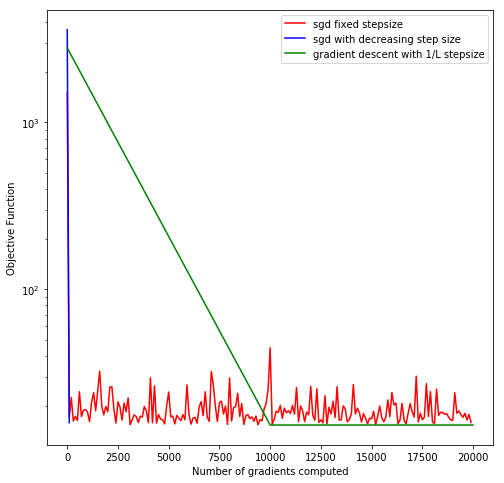

In [13]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of gradients computed')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(0,len(sgd_objectives),100),
         sgd_objectives[0:20000:100],'r', label='sgd fixed stepsize')
plt.plot(range(0,len(sgd_objectives_dec_gamma),100),
         sgd_objectives_dec_gamma[0:20000:100],'b', label='sgd with decreasing step size')
plt.plot(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives,'g', label='gradient descent with 1/L stepsize')
plt.legend(loc='upper right')
plt.show()

# Loading more complex data
The data is taken from https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength 

In [23]:
data = np.loadtxt("concrete_data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [24]:
b.shape, A.shape

((1030,), (1030, 8))

# Running stochastic gradient descent

Test your SGD algorithm on the new dataset. Try different learning rates.

In [54]:
max_iters = 4000

gamma = 0.001

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/3999): objective =     780.94
SGD(0001/3999): objective =     781.10
SGD(0002/3999): objective =     781.36
SGD(0003/3999): objective =     781.70
SGD(0004/3999): objective =     781.97
SGD(0005/3999): objective =     782.13
SGD(0006/3999): objective =     782.38
SGD(0007/3999): objective =     781.87
SGD(0008/3999): objective =     781.56
SGD(0009/3999): objective =     781.94
SGD(0010/3999): objective =     780.41
SGD(0011/3999): objective =     780.71
SGD(0012/3999): objective =     780.92
SGD(0013/3999): objective =     781.42
SGD(0014/3999): objective =     781.61
SGD(0015/3999): objective =     781.63
SGD(0016/3999): objective =     781.81
SGD(0017/3999): objective =     782.01
SGD(0018/3999): objective =     780.42
SGD(0019/3999): objective =     780.69
SGD(0020/3999): objective =     780.59
SGD(0021/3999): objective =     780.76
SGD(0022/3999): objective =     780.42
SGD(0023/3999): objective =     780.51
SGD(0024/3999): objective =     780.80
SGD(0025/3999): objective

SGD(0986/3999): objective =     713.11
SGD(0987/3999): objective =     713.28
SGD(0988/3999): objective =     713.37
SGD(0989/3999): objective =     713.11
SGD(0990/3999): objective =     713.24
SGD(0991/3999): objective =     713.40
SGD(0992/3999): objective =     713.30
SGD(0993/3999): objective =     713.17
SGD(0994/3999): objective =     713.40
SGD(0995/3999): objective =     713.40
SGD(0996/3999): objective =     713.17
SGD(0997/3999): objective =     713.28
SGD(0998/3999): objective =     713.33
SGD(0999/3999): objective =     713.21
SGD(1000/3999): objective =     713.24
SGD(1001/3999): objective =     713.29
SGD(1002/3999): objective =     713.47
SGD(1003/3999): objective =     713.55
SGD(1004/3999): objective =     713.59
SGD(1005/3999): objective =     713.73
SGD(1006/3999): objective =     713.81
SGD(1007/3999): objective =     713.91
SGD(1008/3999): objective =     713.87
SGD(1009/3999): objective =     713.77
SGD(1010/3999): objective =     713.89
SGD(1011/3999): objective

SGD(1863/3999): objective =     704.11
SGD(1864/3999): objective =     704.20
SGD(1865/3999): objective =     704.12
SGD(1866/3999): objective =     704.25
SGD(1867/3999): objective =     704.31
SGD(1868/3999): objective =     704.18
SGD(1869/3999): objective =     704.31
SGD(1870/3999): objective =     704.44
SGD(1871/3999): objective =     704.55
SGD(1872/3999): objective =     704.39
SGD(1873/3999): objective =     704.32
SGD(1874/3999): objective =     704.35
SGD(1875/3999): objective =     704.60
SGD(1876/3999): objective =     704.45
SGD(1877/3999): objective =     704.42
SGD(1878/3999): objective =     704.39
SGD(1879/3999): objective =     704.68
SGD(1880/3999): objective =     704.66
SGD(1881/3999): objective =     704.67
SGD(1882/3999): objective =     704.57
SGD(1883/3999): objective =     704.65
SGD(1884/3999): objective =     704.71
SGD(1885/3999): objective =     704.73
SGD(1886/3999): objective =     704.64
SGD(1887/3999): objective =     704.56
SGD(1888/3999): objective

SGD(2705/3999): objective =     701.73
SGD(2706/3999): objective =     701.92
SGD(2707/3999): objective =     701.85
SGD(2708/3999): objective =     701.60
SGD(2709/3999): objective =     701.75
SGD(2710/3999): objective =     701.68
SGD(2711/3999): objective =     701.68
SGD(2712/3999): objective =     701.64
SGD(2713/3999): objective =     701.52
SGD(2714/3999): objective =     701.38
SGD(2715/3999): objective =     701.44
SGD(2716/3999): objective =     701.34
SGD(2717/3999): objective =     701.30
SGD(2718/3999): objective =     701.30
SGD(2719/3999): objective =     701.30
SGD(2720/3999): objective =     701.40
SGD(2721/3999): objective =     701.34
SGD(2722/3999): objective =     701.47
SGD(2723/3999): objective =     701.59
SGD(2724/3999): objective =     701.72
SGD(2725/3999): objective =     701.83
SGD(2726/3999): objective =     701.91
SGD(2727/3999): objective =     702.00
SGD(2728/3999): objective =     701.74
SGD(2729/3999): objective =     701.67
SGD(2730/3999): objective

SGD(3616/3999): objective =     701.04
SGD(3617/3999): objective =     701.05
SGD(3618/3999): objective =     701.22
SGD(3619/3999): objective =     701.00
SGD(3620/3999): objective =     701.19
SGD(3621/3999): objective =     701.21
SGD(3622/3999): objective =     701.31
SGD(3623/3999): objective =     701.17
SGD(3624/3999): objective =     701.21
SGD(3625/3999): objective =     701.07
SGD(3626/3999): objective =     700.90
SGD(3627/3999): objective =     700.89
SGD(3628/3999): objective =     700.81
SGD(3629/3999): objective =     700.74
SGD(3630/3999): objective =     700.74
SGD(3631/3999): objective =     700.78
SGD(3632/3999): objective =     700.89
SGD(3633/3999): objective =     700.88
SGD(3634/3999): objective =     700.91
SGD(3635/3999): objective =     700.60
SGD(3636/3999): objective =     700.69
SGD(3637/3999): objective =     700.46
SGD(3638/3999): objective =     700.56
SGD(3639/3999): objective =     700.52
SGD(3640/3999): objective =     700.57
SGD(3641/3999): objective

# Plotting the Evolution of the Objective Function

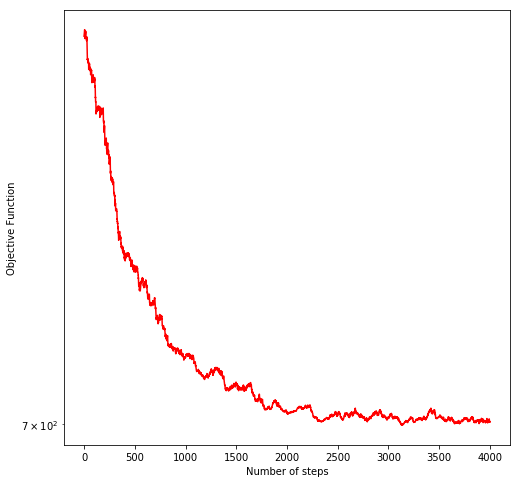

In [55]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(sgd_objectives)), sgd_objectives,'r')

plt.show()

# Projected Stochastic Gradient Descant

To avoid $x$ becoming too big, we can perform constrained optimization by projecting x onto an $\text{L}_2$ ball at each iteration, thus limiting the norm of $x$.

Fill in the `projection` function below, which projects x onto an L2-ball:
(make sure the optimum is inside the l2-ball by choosing an appropriate radius)

In [56]:
l2_ball_radius = 100  # choose an appropriate radius
def projection(x):
    """project x onto an l2-ball"""
    norm = np.linalg.norm(x) 
    if norm > l2_ball_radius:
        x = x * (l2_ball_radius / norm)
    return x

Fill in the `projected_stochastic_gradient_descent` function below:<br>
(Hint: it is the same as stochastic_gradient_descent but with an extra step in the loop)

In [57]:
def projected_stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate=False, 
        projection_fn=lambda x: x):

    """Projected gradient descent."""
    xs = []  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
            
        # update x through the stochastic gradient update
        x -= lr * grad
        
        # project onto the subset
        x = projection_fn(x)
            
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)

        print("SGD({bi}/{ti}): objective={l}".format(
              bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Test your projected SGD function

In [66]:
max_iters = 4000

gamma = 0.001

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/3999): objective=781.0491399526027
SGD(1/3999): objective=780.8790899718158
SGD(2/3999): objective=781.0221633884363
SGD(3/3999): objective=780.5410807457024
SGD(4/3999): objective=780.7180652727498
SGD(5/3999): objective=779.1226602120008
SGD(6/3999): objective=778.6037629284004
SGD(7/3999): objective=778.4630858229503
SGD(8/3999): objective=777.2795042653235
SGD(9/3999): objective=777.6988016619871
SGD(10/3999): objective=777.9174894632941
SGD(11/3999): objective=777.2151115424579
SGD(12/3999): objective=777.4480802401843
SGD(13/3999): objective=777.8440415890561
SGD(14/3999): objective=777.5056889143357
SGD(15/3999): objective=777.7336101539179
SGD(16/3999): objective=778.020147119953
SGD(17/3999): objective=778.1643001384057
SGD(18/3999): objective=778.6093095107867
SGD(19/3999): objective=778.9327219944914
SGD(20/3999): objective=779.23191501523
SGD(21/3999): objective=778.3031881919097
SGD(22/3999): objective=778.413950564628
SGD(23/3999): objective=775.6064270862665
SGD(24

SGD(878/3999): objective=714.1868003327946
SGD(879/3999): objective=714.1693967454651
SGD(880/3999): objective=714.3073626493856
SGD(881/3999): objective=714.2397050186528
SGD(882/3999): objective=713.7342969346804
SGD(883/3999): objective=713.4738008722527
SGD(884/3999): objective=713.6881259985847
SGD(885/3999): objective=713.7400310494862
SGD(886/3999): objective=713.942804473486
SGD(887/3999): objective=714.1308891871004
SGD(888/3999): objective=714.3193962253823
SGD(889/3999): objective=713.5689514264935
SGD(890/3999): objective=713.5317316974078
SGD(891/3999): objective=713.7500586386033
SGD(892/3999): objective=713.7309689680329
SGD(893/3999): objective=713.8045901013298
SGD(894/3999): objective=713.9109502799195
SGD(895/3999): objective=714.1103230206797
SGD(896/3999): objective=714.1981942248173
SGD(897/3999): objective=714.2671659774511
SGD(898/3999): objective=714.4920333654683
SGD(899/3999): objective=714.5616310211719
SGD(900/3999): objective=714.5760958608432
SGD(901/3999

SGD(1700/3999): objective=707.8114634655154
SGD(1701/3999): objective=707.8736760700721
SGD(1702/3999): objective=708.0030304270679
SGD(1703/3999): objective=707.9655411449852
SGD(1704/3999): objective=707.6525857669888
SGD(1705/3999): objective=707.6204587788568
SGD(1706/3999): objective=707.8915175423951
SGD(1707/3999): objective=708.2359027845251
SGD(1708/3999): objective=708.3291406215304
SGD(1709/3999): objective=707.8284797899622
SGD(1710/3999): objective=708.31715587877
SGD(1711/3999): objective=707.9499005602345
SGD(1712/3999): objective=707.6304965429338
SGD(1713/3999): objective=707.9916475548822
SGD(1714/3999): objective=708.2727529407671
SGD(1715/3999): objective=708.2307750529336
SGD(1716/3999): objective=708.1757800943664
SGD(1717/3999): objective=707.8375486315775
SGD(1718/3999): objective=707.3355264336733
SGD(1719/3999): objective=707.5223958191726
SGD(1720/3999): objective=707.7262715188505
SGD(1721/3999): objective=707.9989835299448
SGD(1722/3999): objective=707.8827

SGD(2525/3999): objective=700.4172383340992
SGD(2526/3999): objective=700.4526740127261
SGD(2527/3999): objective=700.4838171356753
SGD(2528/3999): objective=700.457748259878
SGD(2529/3999): objective=700.5079773419719
SGD(2530/3999): objective=700.5414505640298
SGD(2531/3999): objective=700.5783625273571
SGD(2532/3999): objective=700.5834141248208
SGD(2533/3999): objective=700.5814215310877
SGD(2534/3999): objective=700.560750191831
SGD(2535/3999): objective=700.5525937616084
SGD(2536/3999): objective=700.5313711860697
SGD(2537/3999): objective=700.534769221412
SGD(2538/3999): objective=700.6158322574022
SGD(2539/3999): objective=700.6953179496322
SGD(2540/3999): objective=700.6629184612584
SGD(2541/3999): objective=700.5804722170245
SGD(2542/3999): objective=700.5056886088436
SGD(2543/3999): objective=700.4866599087345
SGD(2544/3999): objective=700.5616403327685
SGD(2545/3999): objective=700.6001502441906
SGD(2546/3999): objective=700.6557819861885
SGD(2547/3999): objective=700.70626

SGD(3332/3999): objective=703.3356396136959
SGD(3333/3999): objective=703.3237342736368
SGD(3334/3999): objective=703.4803799915505
SGD(3335/3999): objective=703.798437759254
SGD(3336/3999): objective=703.6925249606323
SGD(3337/3999): objective=703.8580807038495
SGD(3338/3999): objective=703.9910903474308
SGD(3339/3999): objective=704.0851088758235
SGD(3340/3999): objective=703.9556882529031
SGD(3341/3999): objective=704.0236963161357
SGD(3342/3999): objective=703.8790149583843
SGD(3343/3999): objective=703.7499469204848
SGD(3344/3999): objective=703.2349693738869
SGD(3345/3999): objective=703.0792016051735
SGD(3346/3999): objective=702.8635740812874
SGD(3347/3999): objective=702.9364619622074
SGD(3348/3999): objective=702.6650367933655
SGD(3349/3999): objective=702.789781713684
SGD(3350/3999): objective=702.7894888719032
SGD(3351/3999): objective=702.9913378538562
SGD(3352/3999): objective=702.9075030688642
SGD(3353/3999): objective=702.7126408831172
SGD(3354/3999): objective=702.5938

Plot the error

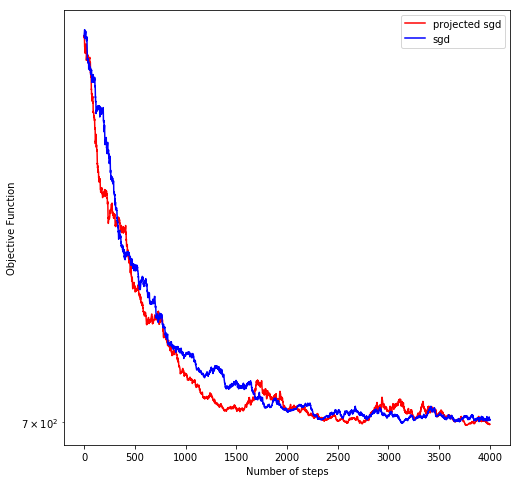

In [67]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(psgd_objectives)), psgd_objectives,'r', label='projected sgd')
plt.plot(range(len(sgd_objectives)), sgd_objectives,'b', label='sgd')
plt.legend(loc='upper right')
plt.show()